In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from nats import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [8]:
N = 60
K = 3
D = 2

## Model Parameters
MCMC_SIZE = 10
SAMPLE_SIZE = 10
NUM_HIDDEN1 = 8
NUM_HIDDEN2 = 16
NUM_STATS = 1 + 2 * D
NUM_LATENTS =  D
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 20
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'ag-all-init-tau'

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/obs.npy')).float()
STATES = torch.from_numpy(np.load('gmm_dataset/states.npy')).float()
OBS_MU = torch.from_numpy(np.load('gmm_dataset/obs_mu.npy')).float()
OBS_SIGMA = torch.from_numpy(np.load('gmm_dataset/obs_sigma.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [4]:
class Enc_eta(nn.Module):
    def __init__(self, num_obs=D,
                       num_hidden1=NUM_HIDDEN1,
                       num_stats=NUM_STATS,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()

        self.mus_mu = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        self.mus_log_nu = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        
        self.tau_log_alpha = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        
        self.tau_log_beta = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        
        self.prior_mu = torch.zeros((K, D))
        self.prior_nu = torch.ones((K, D)) * 0.5
        self.prior_alpha = torch.ones((K, D)) * 3
        self.prior_beta = torch.ones((K, D)) * 3
        if CUDA:
            self.prior_mu = self.prior_mu.cuda()
            self.prior_nu = self.prior_nu.cuda()
            self.prior_alpha = self.prior_alpha.cuda()
            self.prior_beta = self.prior_beta.cuda()
        
    def forward(self, stat1, stat2, stat3):
        q = probtorch.Trace()
        stats_c1 = torch.cat((stat1[:, :, 0].unsqueeze(-1), stat2[:, :, 0, :], stat3[:, :, 0, :]), -1) ## S * B * 1+2*D
        stats_c2 = torch.cat((stat1[:, :, 1].unsqueeze(-1), stat2[:, :, 1, :], stat3[:, :, 1, :]), -1) ## S * B * 1+2*D
        stats_c3 = torch.cat((stat1[:, :, 2].unsqueeze(-1), stat2[:, :, 2, :], stat3[:, :, 2, :]), -1) ## S * B * 1+2*D
        ##
        q_alpha1 = self.tau_log_alpha(stats_c1).exp()
        q_beta1 = self.tau_log_beta(stats_c1).exp()
        q_alpha2 = self.tau_log_alpha(stats_c2).exp()
        q_beta2 = self.tau_log_beta(stats_c2).exp()
        q_alpha3 = self.tau_log_alpha(stats_c3).exp()
        q_beta3 = self.tau_log_beta(stats_c3).exp()
        ##
        q_alpha = torch.cat((q_alpha1.unsqueeze(-2), q_alpha2.unsqueeze(-2), q_alpha3.unsqueeze(-2)), -2)
        q_beta = torch.cat((q_beta1.unsqueeze(-2), q_beta2.unsqueeze(-2), q_beta3.unsqueeze(-2)), -2)
        precisions = Gamma(q_alpha, q_beta).sample()
        q.gamma(q_alpha,
                q_beta,
                value=precisions,
                name='precisions')
        
        p = probtorch.Trace()
        p.gamma(self.prior_alpha,
                self.prior_beta,
                value=q['precisions'],
                name='precisions')   
        ##
        q_mu1 = self.mus_mu(stats_c1)
        q_nu1 = self.mus_log_nu(stats_c1).exp()
        q_mu2 = self.mus_mu(stats_c2)
        q_nu2 = self.mus_log_nu(stats_c2).exp()  
        q_mu3 = self.mus_mu(stats_c3)
        q_nu3 = self.mus_log_nu(stats_c3).exp()     
        
        q_mu = torch.cat((q_mu1.unsqueeze(-2), q_mu2.unsqueeze(-2), q_mu3.unsqueeze(-2)), -2)
        q_nu = torch.cat((q_nu1.unsqueeze(-2), q_nu2.unsqueeze(-2), q_nu3.unsqueeze(-2)), -2)
        ##
        means = Normal(q_mu, 1. / (q_nu * q['precisions'].value).sqrt()).sample()
        q.normal(q_mu, 
                 1. / (q_nu * q['precisions'].value).sqrt(), 
                 value=means, 
                 name='means')
        p.normal(self.prior_mu, 
                 1. / (self.prior_nu * q['precisions'].value).sqrt(), 
                 value=q['means'], 
                 name='means')    
        return q, p, q_nu

class Enc_z(nn.Module):
    def __init__(self, num_obs=D+K*D+K*D,
                       num_hidden=D+K*D+K*D,
                       num_latents=K):
        super(self.__class__, self).__init__()
        self.pi_prob = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Linear(int(0.5*num_hidden), num_latents),
            nn.Softmax(-1))
        
        self.prior_pi = torch.ones(K) * (1./ K)
        if CUDA:
            self.prior_pi = self.prior_pi.cuda()
  
    def forward(self, obs, obs_tau, obs_mu, sample_size, batch_size):
        q = probtorch.Trace()
        obs_tau = obs_tau.view(sample_size, batch_size, K*D).unsqueeze(-2).repeat(1,1,N,1)
        obs_mu = obs_mu.view(sample_size, batch_size, K*D).unsqueeze(-2).repeat(1,1,N,1)
        data = torch.cat((obs, obs_mu, obs_tau), -1) ## S * B * N * (D+K*D+K*D)
        z_pi = self.pi_prob(data)
        z = cat(z_pi).sample()
        _ = q.variable(cat, probs=z_pi, value=z, name='zs')


        p = probtorch.Trace()
        _ = p.variable(cat, probs=self.prior_pi, value=z, name='zs')
        return q, p
    
def initialize():
    enc_eta = Enc_eta()
    enc_z = Enc_z()
    if CUDA:
        enc_eta.cuda()
        enc_z.cuda()
    optimizer =  torch.optim.Adam(list(enc_z.parameters())+list(enc_eta.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_z, enc_eta, optimizer

In [5]:
def Eubo_ag(data, K, D, mcmc_size, sample_size, batch_size):

    for m in range(mcmc_size):
        if m == 0:
            states = cat(torch.ones(K)* (1. / K)).sample((sample_size, batch_size, N,)).cuda()
        ## update tau and mu -- global variables
        stat1, stat2, stat3 = data_to_stats(obs, states, K, D)
        ##
        q_eta, p_eta, q_nu = enc_eta(stat1, stat2, stat3)
        ## for individual importance weight, S * B * K
        log_q_mu = q_eta['means'].log_prob.sum(-1)
        log_q_tau = q_eta['precisions'].log_prob.sum(-1)
        log_p_mu = p_eta['means'].log_prob.sum(-1)
        log_p_tau = p_eta['precisions'].log_prob.sum(-1)
        obs_mu = q_eta['means'].value
        obs_tau = q_eta['precisions'].value
        obs_sigma = 1. / obs_tau.sqrt()
        ##
        labels = states.argmax(-1)
        labels_flat = labels.unsqueeze(-1).repeat(1, 1, 1, D)
        obs_mu_expand = torch.gather(obs_mu, 2, labels_flat)
        obs_sigma_expand = torch.gather(obs_sigma, 2, labels_flat)
        log_obs = Normal(obs_mu_expand, obs_sigma_expand).log_prob(obs).sum(-1) ## S * B * N, need to group
        log_obs = torch.cat([((labels==k).float() * log_obs).sum(-1).unsqueeze(-1) for k in range(K)], -1)
        log_weights_eta = log_obs + log_p_mu + log_p_tau - log_q_mu - log_q_tau
        weights_eta = F.softmax(log_weights_eta, 0).detach()
        eubo_eta = (weights_eta * log_weights_eta).sum(0).sum(-1).mean()
        elbo_eta = log_weights_eta.sum(-1).mean()
        ess_eta = (1. / (weights_eta**2).sum(0)).mean(-1).mean()
        eubo_eta.backward(retain_graph=True)        
        ## update z -- cluster assignments    
        q_z, p_z = enc_z(obs, obs_tau, obs_mu, sample_size, batch_size)
        log_q_z = q_z['zs'].log_prob ## S * B * N
        log_p_z = p_z['zs'].log_prob ## S * B * N
        states = q_z['zs'].value ## S * B * N * K
        labels = states.argmax(-1)
        labels_flat = labels.unsqueeze(-1).repeat(1, 1, 1, D)
        obs_mu_expand = torch.gather(obs_mu, 2, labels_flat)
        obs_sigma_expand = torch.gather(obs_sigma, 2, labels_flat)
        log_obs = Normal(obs_mu_expand, obs_sigma_expand).log_prob(obs).sum(-1) ## S * B * N  
        log_weights_z = log_obs + log_p_z - log_q_z
        weights_z = F.softmax(log_weights_z, 0).detach()
        eubo_z = (weights_z * log_weights_z).sum(0).sum(-1).mean()
        elbo_z = log_weights_z.sum(-1).mean()
        ess_z = (1. / (weights_z**2).sum(0)).mean(-1).mean()
        eubo_z.backward(retain_graph=True)

    ## KLs for mu and sigma based on Normal-Gamma prior
    q_mu = q_eta['means'].dist.loc
    q_alpha = q_eta['precisions'].dist.concentration
    q_beta = q_eta['precisions'].dist.rate 
    q_pi = q_z['zs'].dist.probs
    stat1, stat2, stat3 = data_to_stats(obs, states, K, D)
    post_mu, post_nu, post_alpha, post_beta = Post_mu_tau(stat1, stat2, stat3, enc_eta.prior_mu, enc_eta.prior_nu, enc_eta.prior_alpha, enc_eta.prior_beta, D)
    kl_eta_ex, kl_eta_in = kls_NGs(q_mu, q_nu, q_alpha, q_beta, post_mu, post_nu, post_alpha, post_beta)
    kl_eta_ex = (weights_eta * kl_eta_ex).sum(0).sum(-1).mean()
    kl_eta_in = (weights_eta * kl_eta_in).sum(0).sum(-1).mean()
    ## KLs for cluster assignments
    post_pi = Post_z(obs, obs_tau, obs_mu, N, K)
    kl_z_ex, kl_z_in = kls_cats(q_pi, post_pi, EPS=1e-8)
    kl_z_ex = (weights_z * kl_z_ex).sum(0).sum(-1).mean()    
    kl_z_in = (weights_z * kl_z_in).sum(0).sum(-1).mean()   

    return eubo_eta+eubo_z, elbo_eta+elbo_z, ess_eta+ess_z / 2, kl_eta_ex, kl_eta_in, kl_z_ex, kl_z_in

In [6]:
enc_z, enc_eta, optimizer = initialize()

In [10]:
optimizer2 =  torch.optim.Adam(list(enc_z.parameters())+list(enc_eta.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
flog = open('results/log-' + PATH + '.txt', 'a+')
flog.write('EUBO\tELBO\tESS\tKLs_eta_ex\tKLs_eta_in\tKLs_z_ex\tKLs_z_in\n')
flog.close()
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    KL_eta_ex = 0.0
    KL_eta_in = 0.0
    KL_z_ex = 0.0
    KL_z_in = 0.0
    
    for step in range(NUM_BATCHES):
        optimizer2.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            obs =obs.cuda()
        eubo, elbo, ess, kl_eta_ex, kl_eta_in, kl_z_ex, kl_z_in = Eubo_ag(obs, K, D, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE)
        ## gradient step
        optimizer2.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        KL_eta_ex += kl_eta_ex.item() 
        KL_eta_in += kl_eta_in.item()
        KL_z_ex += kl_z_ex.item() 
        KL_z_in += kl_z_in.item()
        
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, KL_eta_ex/NUM_BATCHES, KL_eta_in/NUM_BATCHES, KL_z_ex/NUM_BATCHES, KL_z_in/NUM_BATCHES), file=flog)
    flog.close()
 
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, eta_ex=%.3f, eta_in=%.3f, z_ex=%.3f, z_in=%.3f (%ds)'
        % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, 
           KL_eta_ex/NUM_BATCHES, KL_eta_in/NUM_BATCHES, KL_z_ex/NUM_BATCHES, KL_z_in/NUM_BATCHES, time_end - time_start))

epoch=0, EUBO=-418.858, ELBO=-520.136, ESS=5.591, eta_ex=10.591, eta_in=11.402, z_ex=0.962, z_in=0.522 (63s)
epoch=1, EUBO=-418.233, ELBO=-518.544, ESS=5.607, eta_ex=10.356, eta_in=12.028, z_ex=0.964, z_in=0.510 (58s)
epoch=2, EUBO=-418.387, ELBO=-518.234, ESS=5.614, eta_ex=10.355, eta_in=12.287, z_ex=0.979, z_in=0.525 (63s)
epoch=3, EUBO=-418.807, ELBO=-518.625, ESS=5.610, eta_ex=10.386, eta_in=12.131, z_ex=0.998, z_in=0.538 (63s)
epoch=4, EUBO=-418.965, ELBO=-518.358, ESS=5.625, eta_ex=10.366, eta_in=12.464, z_ex=0.946, z_in=0.510 (63s)
epoch=5, EUBO=-418.650, ELBO=-517.490, ESS=5.625, eta_ex=10.049, eta_in=11.938, z_ex=0.955, z_in=0.505 (62s)
epoch=6, EUBO=-418.371, ELBO=-517.910, ESS=5.611, eta_ex=10.235, eta_in=12.277, z_ex=0.940, z_in=0.509 (61s)
epoch=7, EUBO=-418.500, ELBO=-518.144, ESS=5.611, eta_ex=10.260, eta_in=11.996, z_ex=0.967, z_in=0.533 (60s)
epoch=8, EUBO=-418.178, ELBO=-516.897, ESS=5.628, eta_ex=10.079, eta_in=12.084, z_ex=0.951, z_in=0.519 (62s)
epoch=9, EUBO=-418.

KeyboardInterrupt: 

In [ ]:
torch.save(enc_eta.state_dict(), 'weights/enc-%s' + PATH)

In [ ]:
def plot_results(EUBOs, ELBOs, ESSs, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(15, 15))
    fig.tight_layout()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')

    ax1.tick_params(labelsize=18)
    
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-240, -100])
    ax1.legend()
    ax3.legend()
    ax3.tick_params(labelsize=18)
    ax3.set_ylim([0,1])
    plt.savefig('train_' + PATH + '.svg')

In [ ]:
plot_results(EUBOs, ELBOs, ESSs, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [37]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
    if CUDA:
        obs =obs.cuda()[:, :, :, :2]
    return obs

def test(mcmc_size, sample_size, batch_size):
    LLs = []
    for m in range(mcmc_size):
        if m == 0:
            states = cat(torch.ones(K)* (1. / K)).sample((sample_size, batch_size, N,)).cuda()
        ## update tau and mu -- global variabl
        stat1, stat2, stat3 = data_to_stats(obs, states, K, D)
        ##
        q_eta, p_eta, q_nu = enc_eta(stat1, stat2, stat3)

        obs_mu = q_eta['means'].value
        obs_tau = q_eta['precisions'].value
        obs_sigma = 1. / obs_tau.sqrt() 
        ## update z -- cluster assignments    
        q_z, p_z = enc_z(obs, obs_tau, obs_mu, sample_size, batch_size)
        states = q_z['zs'].value ## S * B * N * K
        labels = states.argmax(-1)
        labels_flat = labels.unsqueeze(-1).repeat(1, 1, 1, D)
        obs_mu_expand = torch.gather(obs_mu, 2, labels_flat)
        obs_sigma_expand = torch.gather(obs_sigma, 2, labels_flat)
        log_obs = Normal(obs_mu_expand, obs_sigma_expand).log_prob(obs).sum(-1).sum(-1) ## S * B
        ll = (log_obs + p_eta['means'].log_prob.sum(-1).sum(-1) + p_eta['precisions'].log_prob.sum(-1).sum(-1) + p_z['zs'].log_prob.sum(-1)).mean(0).unsqueeze(0)
        LLs.append(ll)
    LLs = torch.cat(LLs, 0).cpu()
    return LLs, states, q_eta

def plot_ll(LLs, batch_size):
    fig = plt.figure(figsize=(15,15))
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        ax.plot(LLs[:, b].data.numpy())
        
def plot_samples(obs, states, q, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(15,15))
    xs = obs[0].cpu()
    zs = states[0].cpu()
    mu_means = q['means'].dist.loc[0].cpu().data.numpy()
    tau_means = (q['precisions'].dist.concentration[0] / q['precisions'].dist.rate[0]).cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b].data.numpy()
        z = zs[b].data.numpy()
        mu = mu_means[b].reshape(K, D)
        sigma2 = 1. / tau_means[b]
        assignments = z.argmax(-1)
        for k in range(K):
            cov_k = np.diag(sigma2[k]**2)
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-15, 15])
        ax.set_xlim([-15, 15])
    plt.savefig('results/modes-' + PATH + '.svg')        

In [40]:
LLs.shape

torch.Size([20, 25])

In [38]:
BATCH_SIZE_TEST = 25
obs = sample_single_batch(NUM_SEQS, N, K, D, BATCH_SIZE_TEST)

CPU times: user 0 ns, sys: 2 µs, total: 2 µs
Wall time: 5.48 µs


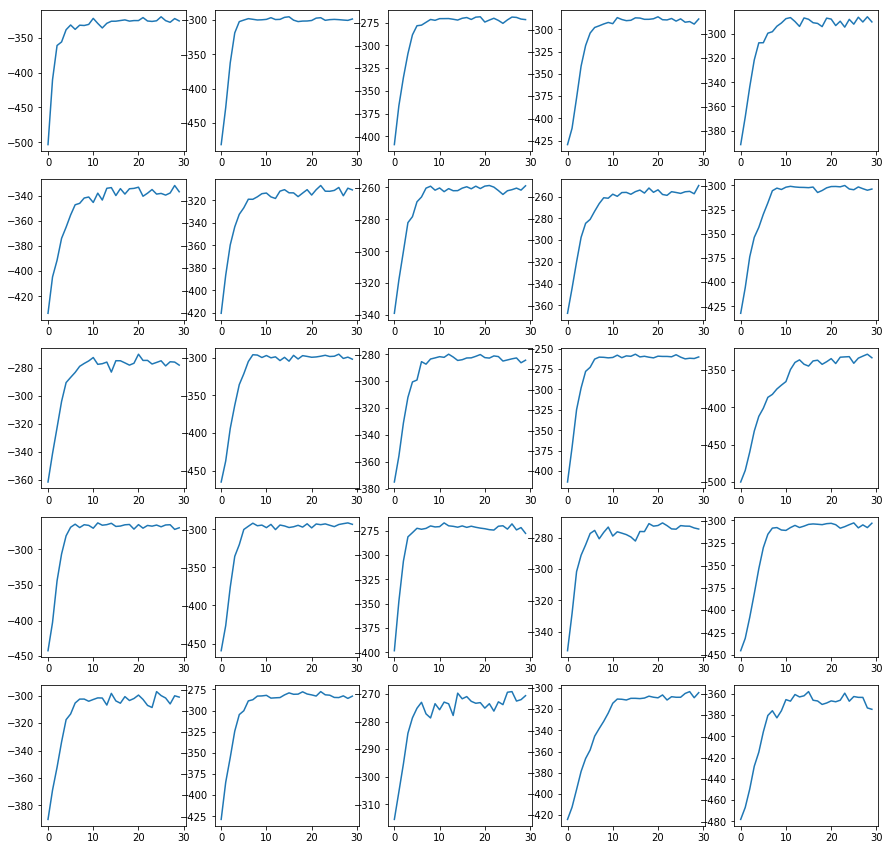

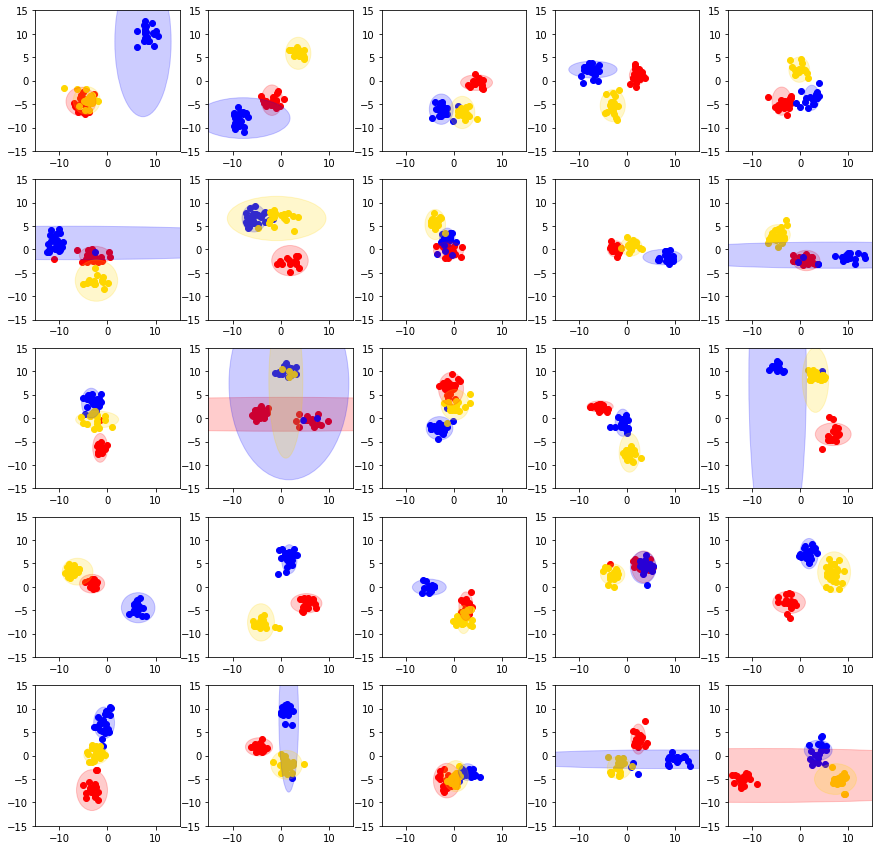

In [44]:
MCMC_SIZE = 30
LLs, states, q_eta = test(MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE_TEST)
plot_ll(LLs, BATCH_SIZE_TEST)
plot_samples(obs, states, q_eta, BATCH_SIZE_TEST)
%time